# DMRG

In this notebook we will study the ground state of a spin Hamiltonian
$$H = \sum_{i=1}^N \sigma^z_i \sigma^z_i + h \sum_i \sigma^x_i$$
using matrix product states and the density matrix renormalization group algorithm (DMRG in short).

First, we assume the SeeMPS library has been installed in the environment, and import a set of tools.

In [1]:
from seemps.hamiltonians import ConstantTIHamiltonian
from seemps.optimization import dmrg
from seemps.state import MPS, product_state
import numpy as np

Next, we define our operators. The `ConstantTIHamiltonian` class is a tool to construct matrix product operators for a given problem. It allows you to define the interaction between nearest-neighbor sites and some local terms, and move ahead.

In [2]:
N = 10
h = 0.2
sx = np.array([[0, 1], [1, 0]])
sz = np.array([[1, 0], [0, -1]])
H = ConstantTIHamiltonian(size=N, interaction=np.kron(sz, sz), local_term=h * sx)

We use the DMRG algorithm with a suitable guess to find out the ground state energy

In [3]:
result = dmrg(H, guess=product_state(np.ones(2) / np.sqrt(2), N))
print(f"DMRG energy = {result.energy}")

DMRG energy = -9.100252539845778


We can compare with the exact diagonalization, because the problem is small

In [4]:
from scipy.sparse.linalg import eigsh

E, _ = eigsh(H.to_matrix(), k=1, which="SA")
print(f"Exact energy = {result.energy}")

Exact energy = -9.100252539845778


With this, we can do a slightly more sophisticated study of the quantum phase transition.

Energy = -14.000000, time = 0.029828s, errors: E = 1.776357e-15, Sz = -8.881784e-15, Sx = 2.506642e-15
Energy = -14.037523, time = 2.142771s, errors: E = 5.329071e-15, Sz = 7.105427e-15, Sx = 2.109424e-14
Energy = -14.150379, time = 2.367645s, errors: E = 2.664535e-14, Sz = 3.552714e-14, Sx = 3.352874e-14
Energy = -14.339443, time = 2.464049s, errors: E = 8.881784e-15, Sz = 4.067857e-13, Sx = 1.408651e-12
Energy = -14.606256, time = 2.892130s, errors: E = 1.065814e-14, Sz = 8.171241e-14, Sx = 2.136069e-13
Energy = -14.953166, time = 2.870381s, errors: E = 1.101341e-13, Sz = 4.849454e-13, Sx = 1.219025e-12
Energy = -15.383579, time = 3.121701s, errors: E = 2.309264e-14, Sz = 1.902833e-11, Sx = 3.177725e-11
Energy = -15.902429, time = 5.860231s, errors: E = 0.000000e+00, Sz = -3.215206e-13, Sx = -4.583001e-13
Energy = -16.517102, time = 4.514728s, errors: E = 6.394885e-14, Sz = -1.332268e-13, Sx = -9.059420e-14
Energy = -17.238942, time = 4.499522s, errors: E = 1.776357e-14, Sz = 2.77111

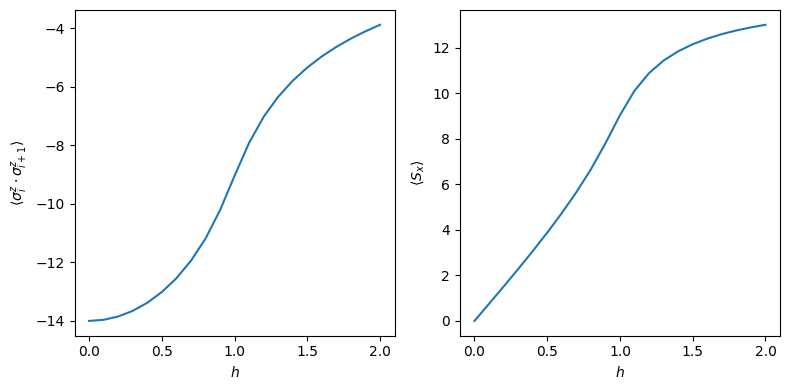

In [5]:
import matplotlib.pyplot as plt
from time import process_time


def experiment_00(N: int = 30, steps: int = 21):
    """Explore the quantum phase transition as a function of the transverse
    magnetic field $h$. Plots the magnetizations of the ground state, computed
    with a small symmetry breaking term."""
    h = np.linspace(0, 2, steps)
    epsilon = 0
    sx = np.array([[0, 1], [1, 0]])
    sz = np.array([[1, 0], [0, -1]])
    sz_values = []
    sx_values = []
    extras = ""

    ZZ = ConstantTIHamiltonian(size=N, interaction=np.kron(sz, sz))
    X = ConstantTIHamiltonian(size=N, local_term=sx)
    for hi in h:
        H = ConstantTIHamiltonian(
            size=N, interaction=np.kron(sz, sz), local_term=-hi * sx + epsilon * sz
        )
        time = process_time()
        result = dmrg(H, guess=product_state(np.ones(2) / np.sqrt(2), N), maxiter=100)
        time = process_time() - time
        sz_values.append(ZZ.to_mpo().expectation(result.state))
        sx_values.append(X.to_mpo().expectation(result.state))

        if N <= 20:
            E, psi0 = eigsh(H.to_matrix(), v0=result.state.to_vector(), k=1, which="SA")
            E = E[0]
            psi0 = psi0[:, 0]
            sz_exact = np.vdot(psi0, ZZ.to_matrix() @ psi0)
            sx_exact = np.vdot(psi0, X.to_matrix() @ psi0)
            extras = (
                f", errors: E = {abs(E - result.energy):6e}, "
                f"Sz = {sz_exact - sz_values[-1]:6e}, "
                f"Sx = {sx_exact - sx_values[-1]:6e}"
            )
        print(f"Energy = {result.energy:+6f}, time = {time:5f}s" + extras)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
    ax1.plot(h, sz_values)
    ax1.set_xlabel(r"$h$")
    ax1.set_ylabel(r"$\langle{\sigma^z_{i}\cdot \sigma^z_{i+1}}\rangle$")
    ax2.plot(h, sx_values)
    ax2.set_xlabel(r"$h$")
    ax2.set_ylabel(r"$\langle{S_x}\rangle$")
    fig.tight_layout()


experiment_00(N=15)

Energy = -29.000000, time = 0.046403s
Energy = -29.033343, time = 0.071777s
Energy = -29.133482, time = 0.071953s
Energy = -29.300758, time = 0.078411s
Energy = -29.535747, time = 0.079907s
Energy = -29.839289, time = 0.075377s
Energy = -30.212513, time = 0.111238s
Energy = -30.656891, time = 0.116529s
Energy = -31.174306, time = 0.521015s
Energy = -31.767158, time = 2.452191s
Energy = -32.438524, time = 3.186177s
Energy = -33.192426, time = 5.830664s
Energy = -34.034285, time = 5.676823s
Energy = -34.971833, time = 7.210695s
Energy = -36.017132, time = 12.750457s
Energy = -37.188459, time = 15.034433s
Energy = -38.492202, time = 8.518153s
Energy = -39.901845, time = 8.247163s
Energy = -41.388578, time = 6.614665s
Energy = -42.933963, time = 7.003286s
Energy = -44.525857, time = 6.596232s
Energy = -46.155649, time = 6.717984s
Energy = -47.816927, time = 6.071538s
Energy = -49.504756, time = 5.259970s
Energy = -51.215244, time = 1.348716s
Energy = -52.945263, time = 5.589124s
Energy = -

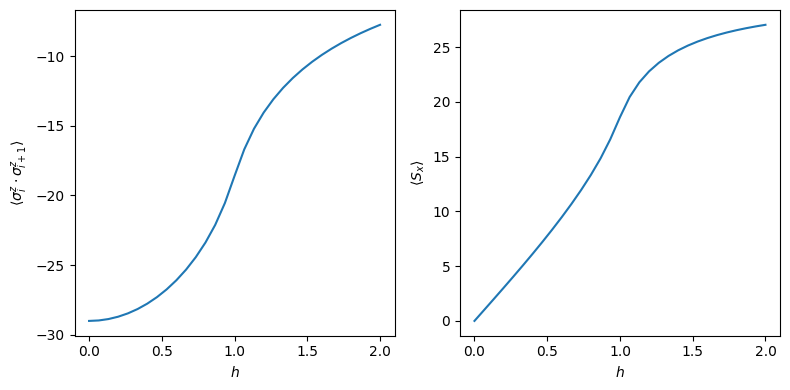

In [6]:
experiment_00(N=30, steps=31)